In [ ]:
!git clone https://github.com/vijay-0107/quantum_ml_classifier.git

Cloning into 'quantum_ml_classifier'...
remote: Enumerating objects: 5625, done.
remote: Counting objects: 100% (5625/5625), done.
remote: Compressing objects: 100% (5620/5620), done.
remote: Total 5625 (delta 6), reused 5610 (delta 1), pack-reused 0
Receiving objects: 100% (5625/5625), 22.60 MiB | 8.75 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
!pip install opencv-python

In [ ]:
!pip install qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 12.8 MB/s eta 0:00:00


In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 37.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import cv2
import random
import pennylane as qml
from qiskit import QuantumCircuit, transpile, assemble, Aer, execute
from qiskit.circuit import Parameter
from qiskit.visualization import plot_bloch_multivector
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from pennylane.templates import RandomLayers
from google.colab.patches import cv2_imshow
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from scipy.stats import ttest_rel
from sklearn.model_selection import train_test_split

In [ ]:
data_dir = "/content/quantum_ml_classifier/Data/Satellite_images"

class_dir = os.listdir(data_dir)

data = []
for classname in class_dir:
  class_path = os.path.join(data_dir, classname)
  img_list = os.listdir(class_path)
  class_data = []
  for imagename in img_list:
    img_path = os.path.join(class_path, imagename)
    image_read = cv2.imread(img_path)
    # cv2_imshow(image_read)
    resize_img = cv2.resize(image_read, (28, 28), interpolation=cv2.INTER_CUBIC)
    img_norm = resize_img / 255.0
    class_data.append(img_norm)
  data.append(class_data)

In [ ]:
num_samples = 2500
num_test = 500
total_data_train = []
total_data_test = []

for i in range(len(data)):
  num_of_selections = 1200
  if (len(data[i]) < 1200):
    num_of_selections = 1000
  for j in range(num_of_selections):
    data_point = []
    data_point.append(data[i][j])
    data_point.append(i)
    total_data_train.append(data_point)

for i in range(len(data)):
  num_of_selections = 130
  start = 1200
  if (len(data[i]) < 1200):
    start = 1000
  for j in range(start, len(data[i])):
    data_point = []
    data_point.append(data[i][j])
    data_point.append(i)
    total_data_test.append(data_point)

final_train_data = sorted(total_data_train, key=lambda x: random.random())
final_test_data = sorted(total_data_test, key=lambda x: random.random())

train_data = random.choices(final_train_data, k = num_samples)
test_data = random.choices(final_test_data, k = num_test)

print(len(train_data))

2500


##First Implement


In [ ]:
n_epochs = 100   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = len(train_data)   # Size of the train dataset
n_test = len(test_data)     # Size of the test dataset

SAVE_PATH_1 = "/content/quantum_ml_classifier/Data/processed_data/q" # Data saving folder
SAVE_PATH_2 = "/content/q"
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [ ]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev, interface="autograd")
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k],
                    image[j, k + 1],
                    image[j + 1, k],
                    image[j + 1, k + 1]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
train_labels = []
test_labels = []

if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    idx = 0
    for sample in train_data:
        img = sample[0]
        val = sample[1]
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
        train_labels.append(val)
        idx = idx + 1
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    idx = 0
    for sample in test_data:
        img = sample[0]
        val = sample[1]
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
        train_labels.append(val)
        idx = idx + 1
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

train_label = np.array(train_labels)
test_label = np.array(test_labels)

Quantum pre-processing of train images:


KeyboardInterrupt: ignored

In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
q_model = MyModel()

n_epochs = 30

q_history = q_model.fit(
    q_train_images,
    train_label,
    validation_data=(q_test_images, test_label),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
625/625 - 2s - loss: 0.8049 - accuracy: 0.5340 - val_loss: 0.8165 - val_accuracy: 0.5360 - 2s/epoch - 3ms/step
Epoch 2/30
625/625 - 1s - loss: 0.7380 - accuracy: 0.5644 - val_loss: 0.7947 - val_accuracy: 0.5700 - 1s/epoch - 2ms/step
Epoch 3/30
625/625 - 2s - loss: 0.7438 - accuracy: 0.5736 - val_loss: 0.7928 - val_accuracy: 0.5760 - 2s/epoch - 3ms/step
Epoch 4/30
625/625 - 1s - loss: 0.7110 - accuracy: 0.5880 - val_loss: 0.7618 - val_accuracy: 0.5780 - 1s/epoch - 2ms/step
Epoch 5/30
625/625 - 1s - loss: 0.7189 - accuracy: 0.5800 - val_loss: 0.7496 - val_accuracy: 0.5580 - 1s/epoch - 2ms/step
Epoch 6/30
625/625 - 1s - loss: 0.7035 - accuracy: 0.5924 - val_loss: 0.6617 - val_accuracy: 0.5720 - 1s/epoch - 2ms/step
Epoch 7/30
625/625 - 1s - loss: 0.7019 - accuracy: 0.5936 - val_loss: 0.8757 - val_accuracy: 0.5520 - 1s/epoch - 2ms/step
Epoch 8/30
625/625 - 1s - loss: 0.7025 - accuracy: 0.6036 - val_loss: 0.6616 - val_accuracy: 0.6240 - 1s/epoch - 2ms/step
Epoch 9/30
625/625 - 1s 

In [ ]:
train_images = []
test_images = []
for sample in train_data:
  image = sample[0]
  image_list = []
  for row in image:
    row_list = []
    for pixel in row:
      pixel_list = []
      pixel_list.append(pixel)
      pixel_arr = np.array(pixel_list)
      row_list.append(pixel_arr)

    row_arr = np.array(row_list)
    image_list.append(row_arr)

  image_arr = np.array(image_list)
  train_images.append(image_arr)

train_images_arr = np.array(train_images)

for sample in test_data:
  image = sample[0]
  image_list = []
  for row in image:
    row_list = []
    for pixel in row:
      pixel_list = []
      pixel_list.append(pixel)
      pixel_arr = np.array(pixel_list)
      row_list.append(pixel_arr)

    row_arr = np.array(row_list)
    image_list.append(row_arr)

  image_arr = np.array(image_list)
  test_images.append(image_arr)

test_images_arr = np.array(test_images)

NameError: ignored

In [ ]:
c_model = MyModel()

c_history = c_model.fit(
    train_images_arr,
    train_label,
    validation_data=(test_images_arr, test_label),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)


NameError: ignored

<ipython-input-56-c3ef9ba498fb>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


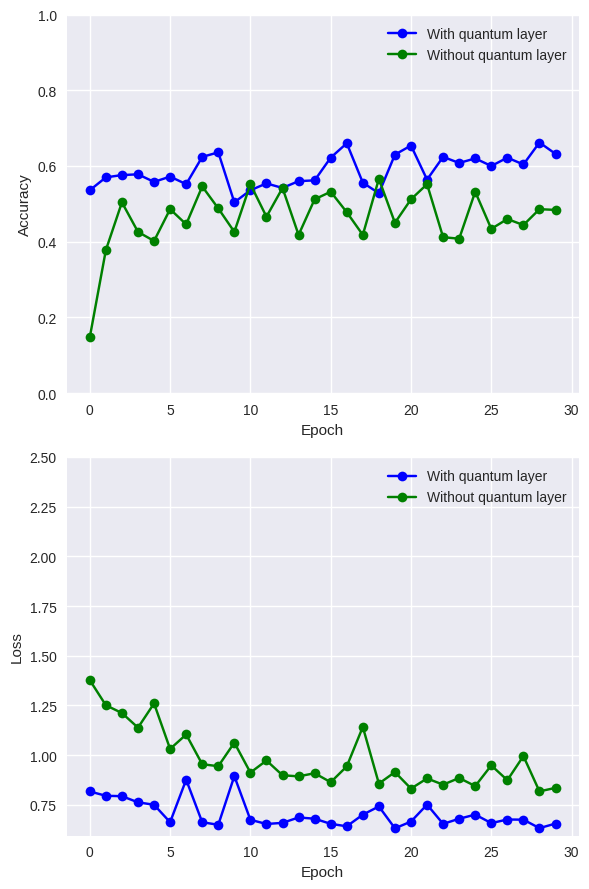

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

# another model


In [ ]:
dev = qml.device("default.qubit", wires=3)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(1, 3))

@qml.qnode(dev, interface="autograd")
def circuit(phi):
    # Encoding of 3 classical input values
    for j in range(3):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(3)))

    # Measurement producing 3 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(3)]

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((28, 28, 3))

    for j in range(28):
      for k in range(28):
        q_result = circuit(image[j,k])
        for c in range(3):
          out[j, k, c] = q_result[c]

    return out

In [ ]:
train_labels = []
test_labels = []

if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    idx = 0
    for sample in train_data:
        img = sample[0]
        val = sample[1]
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
        train_labels.append(val)
        idx = idx + 1
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    idx = 0
    for sample in test_data:
        img = sample[0]
        val = sample[1]
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
        test_labels.append(val)
        idx = idx + 1
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH_1 + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH_1 + "q_test_images.npy", q_test_images)
    np.save(SAVE_PATH_2 + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH_2 + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH_2 + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH_2 + "q_test_images.npy")

train_label = np.array(train_labels)
test_label = np.array(test_labels)

Quantum pre-processing of train images:

Quantum pre-processing of test images:


In [ ]:
print(q_train_images[0].shape)
print(q_train_images[0][0])
print(train_data[0][0][0])

(28, 28, 3)
[[ 0.54205336 -0.19764822 -0.0952151 ]
 [ 0.51063119 -0.18555659 -0.0887384 ]
 [ 0.55236497 -0.19764822 -0.09589478]
 [ 0.53165947 -0.1734368  -0.08355148]
 [ 0.53165947 -0.20970985 -0.10174683]
 [ 0.51063119 -0.13692685 -0.06499146]
 [ 0.54205336 -0.19764822 -0.0952151 ]
 [ 0.53165947 -0.19764822 -0.09655991]
 [ 0.54205336 -0.22173965 -0.10832965]
 [ 0.55236497 -0.20970985 -0.10102567]
 [ 0.54205336 -0.20970985 -0.10245255]
 [ 0.53165947 -0.16129068 -0.07770021]
 [ 0.54205336 -0.14912008 -0.07234995]
 [ 0.52118488 -0.16129068 -0.0765556 ]
 [ 0.52118488 -0.1734368  -0.0858602 ]
 [ 0.54205336 -0.19764822 -0.09655991]
 [ 0.57273514 -0.22173965 -0.10905941]
 [ 0.52118488 -0.20970985 -0.10174683]
 [ 0.51063119 -0.14912008 -0.07234995]
 [ 0.52118488 -0.16129068 -0.07713376]
 [ 0.52118488 -0.18555659 -0.09002818]
 [ 0.53165947 -0.19764822 -0.09655991]
 [ 0.53165947 -0.20970985 -0.10174683]
 [ 0.5        -0.16129068 -0.07713376]
 [ 0.5827906  -0.23373579 -0.11571133]
 [ 0.46765759

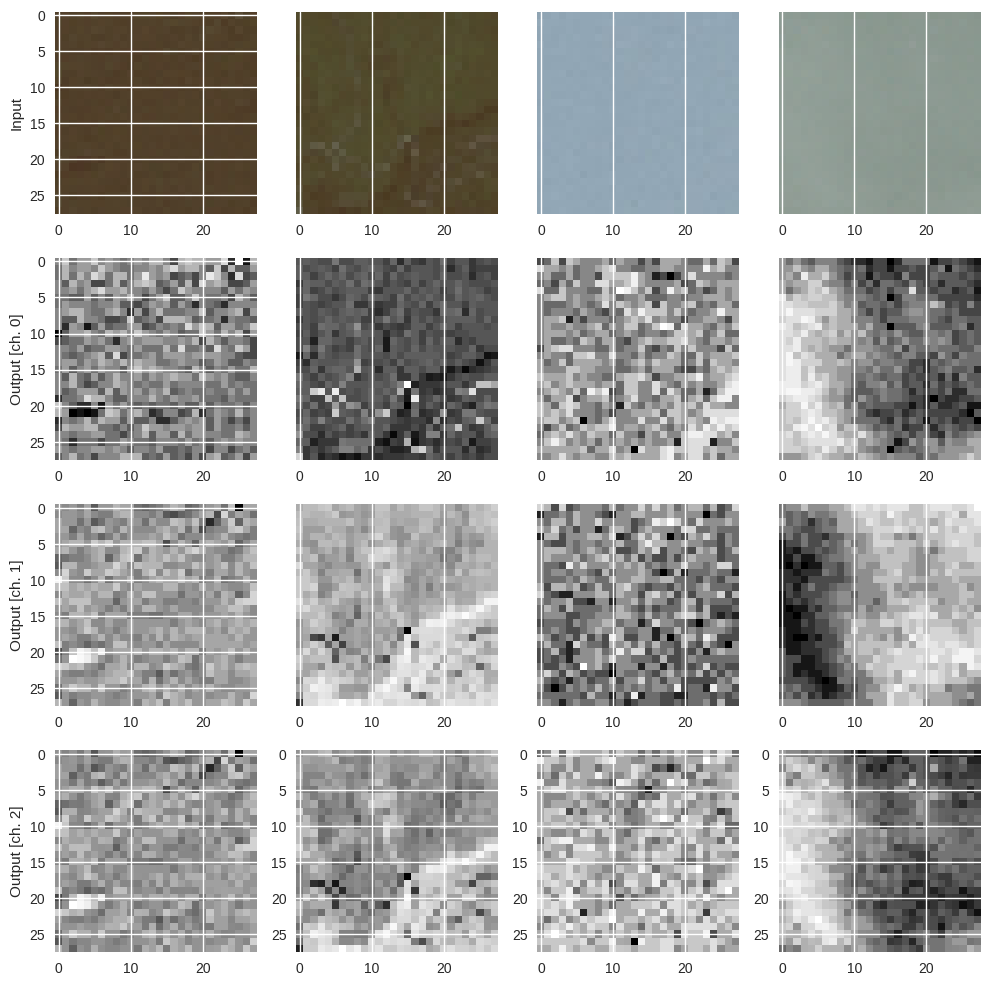

In [ ]:
n_img_show = 4
n_channels = 3
fig, axes = plt.subplots(1 + n_channels, n_img_show, figsize=(10, 10))
for k in range(n_img_show):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_data[k][0])
    # axes[0, k].imshow(train_data[0][k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k][:, :, c])
        # axes[c + 1, k].imshow(q_train_images[k][:, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
train_labels = []
test_labels = []

for sample in train_data:
  val = sample[1]
  train_labels.append(val)

for sample in test_data:
  val = sample[1]
  test_labels.append(val)

train_label = np.array(train_labels)
test_label = np.array(test_labels)

In [ ]:
q_train_images_1 = np.load("/content/quantum_ml_classifier/Data/processed_data/q_train_images.npy")
q_test_images_1 = np.load("/content/quantum_ml_classifier/Data/processed_data/q_test_images.npy")

In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(4, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
def calculate_classification_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    return f1, precision, recall, accuracy

def calculate_t_score_and_p_value(array1, array2):
    t_stat, p_value = ttest_rel(array1, array2)
    return t_stat, p_value

In [ ]:
print(len(q_train_images))
print(len(train_label))
print(len(q_test_images))
print(len(test_label))

2500
2500
500
500


In [ ]:
q_model = MyModel()

n_epochs = 75

q_history = q_model.fit(
    q_train_images,
    train_label,
    validation_data=(q_test_images, test_label),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/75
625/625 - 2s - loss: 0.7703 - accuracy: 0.6516 - val_loss: 0.7049 - val_accuracy: 0.7560 - 2s/epoch - 3ms/step
Epoch 2/75
625/625 - 1s - loss: 0.7008 - accuracy: 0.6884 - val_loss: 0.8832 - val_accuracy: 0.6880 - 1s/epoch - 2ms/step
Epoch 3/75
625/625 - 1s - loss: 0.6548 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.8000 - 1s/epoch - 2ms/step
Epoch 4/75
625/625 - 1s - loss: 0.6263 - accuracy: 0.7248 - val_loss: 0.5892 - val_accuracy: 0.7760 - 1s/epoch - 2ms/step
Epoch 5/75
625/625 - 1s - loss: 0.6274 - accuracy: 0.7320 - val_loss: 0.6366 - val_accuracy: 0.7640 - 1s/epoch - 2ms/step
Epoch 6/75
625/625 - 2s - loss: 0.6403 - accuracy: 0.7352 - val_loss: 0.7083 - val_accuracy: 0.7020 - 2s/epoch - 2ms/step
Epoch 7/75
625/625 - 2s - loss: 0.5821 - accuracy: 0.7516 - val_loss: 0.6227 - val_accuracy: 0.7600 - 2s/epoch - 2ms/step
Epoch 8/75
625/625 - 2s - loss: 0.6037 - accuracy: 0.7356 - val_loss: 0.5810 - val_accuracy: 0.7920 - 2s/epoch - 3ms/step
Epoch 9/75
625/625 - 1s 

In [ ]:
q_y_pred = np.argmax(q_model.predict(q_test_images), axis=1)

16/16 [==============================] - 0s 3ms/step


In [ ]:
# Calculate classification metrics
q_f1, q_precision, q_recall, q_accuracy = calculate_classification_metrics(test_label, q_y_pred)
print("F1 Score:", q_f1)
print("Precision:", q_precision)
print("Recall:", q_recall)
print("Accuracy:", q_accuracy)

# Assuming you have another set of predictions to compare (e.g., predictions from another model or baseline)
# Calculate t-score and p-value
# t_stat, p_value = calculate_t_score_and_p_value(y_pred_baseline, y_pred)
# print("t-score:", t_stat)
# print("p-value:", p_value)

F1 Score: 0.7545319209305863
Precision: 0.7908623181886341
Recall: 0.754
Accuracy: 0.754


In [ ]:
train_images = []
test_images = []
for sample in train_data:
  image = sample[0]
  image_list = []
  for row in image:
    row_list = []
    for pixel in row:
      pixel_list = []
      pixel_list.append(pixel)
      pixel_arr = np.array(pixel_list)
      row_list.append(pixel_arr)

    row_arr = np.array(row_list)
    image_list.append(row_arr)

  image_arr = np.array(image_list)
  train_images.append(image_arr)

train_images_arr = np.array(train_images)

for sample in test_data:
  image = sample[0]
  image_list = []
  for row in image:
    row_list = []
    for pixel in row:
      pixel_list = []
      pixel_list.append(pixel)
      pixel_arr = np.array(pixel_list)
      row_list.append(pixel_arr)

    row_arr = np.array(row_list)
    image_list.append(row_arr)

  image_arr = np.array(image_list)
  test_images.append(image_arr)

test_images_arr = np.array(test_images)

In [ ]:
c_model = MyModel()

c_history = c_model.fit(
    train_images_arr,
    train_label,
    validation_data=(test_images_arr, test_label),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/75
625/625 - 2s - loss: 0.7696 - accuracy: 0.6320 - val_loss: 0.6317 - val_accuracy: 0.6680 - 2s/epoch - 3ms/step
Epoch 2/75
625/625 - 1s - loss: 0.6193 - accuracy: 0.6888 - val_loss: 0.5577 - val_accuracy: 0.6840 - 1s/epoch - 2ms/step
Epoch 3/75
625/625 - 1s - loss: 0.5920 - accuracy: 0.7020 - val_loss: 0.5090 - val_accuracy: 0.7020 - 1s/epoch - 2ms/step
Epoch 4/75
625/625 - 1s - loss: 0.5833 - accuracy: 0.7008 - val_loss: 0.4789 - val_accuracy: 0.7000 - 1s/epoch - 2ms/step
Epoch 5/75
625/625 - 1s - loss: 0.5779 - accuracy: 0.7224 - val_loss: 0.5014 - val_accuracy: 0.6820 - 1s/epoch - 2ms/step
Epoch 6/75
625/625 - 1s - loss: 0.5798 - accuracy: 0.7136 - val_loss: 0.6440 - val_accuracy: 0.6880 - 1s/epoch - 2ms/step
Epoch 7/75
625/625 - 1s - loss: 0.5468 - accuracy: 0.7360 - val_loss: 0.4761 - val_accuracy: 0.7440 - 1s/epoch - 2ms/step
Epoch 8/75
625/625 - 2s - loss: 0.5934 - accuracy: 0.7116 - val_loss: 0.4677 - val_accuracy: 0.7180 - 2s/epoch - 3ms/step
Epoch 9/75
625/625 - 2s 

In [ ]:
c_y_pred = np.argmax(c_model.predict(test_images_arr), axis=1)

16/16 [==============================] - 0s 2ms/step


In [ ]:

# Calculate classification metrics
c_f1, c_precision, c_recall, c_accuracy = calculate_classification_metrics(test_label, c_y_pred)
print("F1 Score:", c_f1)
print("Precision:", c_precision)
print("Recall:", c_recall)
print("Accuracy:", c_accuracy)

# Assuming you have another set of predictions to compare (e.g., predictions from another model or baseline)
# Calculate t-score and p-value
# t_stat, p_value = calculate_t_score_and_p_value(y_pred_baseline, y_pred)
# print("t-score:", t_stat)
# print("p-value:", p_value)

F1 Score: 0.6666800240553014
Precision: 0.7978212000820697
Recall: 0.718
Accuracy: 0.718


<ipython-input-23-457698e1046d>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


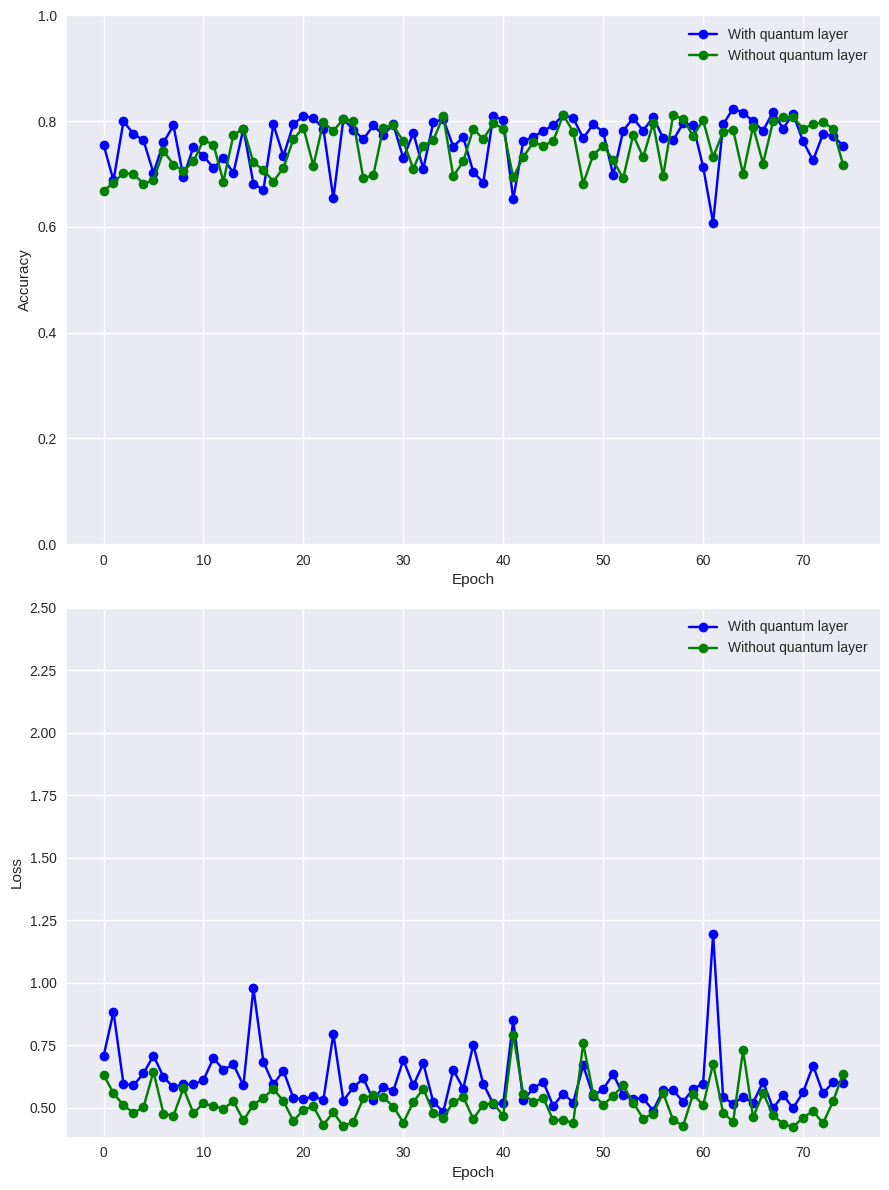

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 12))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

##third implementation

In [ ]:
dev = qml.device("default.qubit", wires=3)
@qml.qnode(dev)
def angle_embedding(angles):
    for i, angle in enumerate(angles):
        qml.RY((np.pi / 2 * angle), wires=i)  # Embed each angle into a qubit
    return qml.expval(qml.PauliZ(2))

drawer = qml.draw(angle_embedding)
quantum_circuits = []
train = train_data[:5]
for images in train:
  img = images[0]
  image_qs = []
  for pixels in img:
    pixel_qs = []
    for pixel in pixels:
      quantum_state = angle_embedding(pixel)
      pixel_qs.append(quantum_state)
    image_qs.append(pixel_qs)
  quantum_circuits.append(image_qs)

for images in train:
  img = images[0]
  for pixels in img:
    for pixel in pixels:
      print(drawer(pixel))
    print(" ")
  print(" ")
  print(" ")
  print(" ")

Streaming output truncated to the last 5000 lines.
0: ──RY(0.39)─┤     
1: ──RY(0.28)─┤     
2: ──RY(0.15)─┤  <Z>
0: ──RY(0.43)─┤     
1: ──RY(0.34)─┤     
2: ──RY(0.19)─┤  <Z>
0: ──RY(0.43)─┤     
1: ──RY(0.33)─┤     
2: ──RY(0.19)─┤  <Z>
0: ──RY(0.41)─┤     
1: ──RY(0.33)─┤     
2: ──RY(0.17)─┤  <Z>
0: ──RY(0.43)─┤     
1: ──RY(0.35)─┤     
2: ──RY(0.20)─┤  <Z>
0: ──RY(0.44)─┤     
1: ──RY(0.36)─┤     
2: ──RY(0.22)─┤  <Z>
0: ──RY(0.39)─┤     
1: ──RY(0.31)─┤     
2: ──RY(0.17)─┤  <Z>
0: ──RY(0.42)─┤     
1: ──RY(0.34)─┤     
2: ──RY(0.20)─┤  <Z>
0: ──RY(0.43)─┤     
1: ──RY(0.34)─┤     
2: ──RY(0.20)─┤  <Z>
0: ──RY(0.41)─┤     
1: ──RY(0.33)─┤     
2: ──RY(0.18)─┤  <Z>
0: ──RY(0.42)─┤     
1: ──RY(0.33)─┤     
2: ──RY(0.19)─┤  <Z>
0: ──RY(0.43)─┤     
1: ──RY(0.36)─┤     
2: ──RY(0.21)─┤  <Z>
0: ──RY(0.42)─┤     
1: ──RY(0.33)─┤     
2: ──RY(0.19)─┤  <Z>
0: ──RY(0.41)─┤     
1: ──RY(0.34)─┤     
2: ──RY(0.19)─┤  <Z>
0: ──RY(0.46)─┤     
1: ──RY(0.39)─┤     
2: ──RY(0.25)─┤  <Z>
0: ─

In [ ]:
print(quantum_circuits)

[[[tensor(0.9686694, requires_grad=True), tensor(0.96963589, requires_grad=True), tensor(0.96963589, requires_grad=True), tensor(0.97058746, requires_grad=True), tensor(0.96963589, requires_grad=True), tensor(0.97058746, requires_grad=True), tensor(0.97058746, requires_grad=True), tensor(0.96963589, requires_grad=True)], [tensor(0.96963589, requires_grad=True), tensor(0.96963589, requires_grad=True), tensor(0.97058746, requires_grad=True), tensor(0.97058746, requires_grad=True), tensor(0.96963589, requires_grad=True), tensor(0.97244582, requires_grad=True), tensor(0.97152411, requires_grad=True), tensor(0.9686694, requires_grad=True)], [tensor(0.97152411, requires_grad=True), tensor(0.97152411, requires_grad=True), tensor(0.97058746, requires_grad=True), tensor(0.97152411, requires_grad=True), tensor(0.97244582, requires_grad=True), tensor(0.97152411, requires_grad=True), tensor(0.97244582, requires_grad=True), tensor(0.96963589, requires_grad=True)], [tensor(0.97244582, requires_grad=

In [ ]:
#####   ALL ROUGH WORK   ######

In [ ]:
# quantum_circuits = []

# for i in range(len(data)):
#   class_qcs = []
#   for j in range(len(data[i])):
#     num_qubits = data[i][j].shape[0] * data[i][j].shape[1]

#     qc = QuantumCircuit(num_qubits)
#     qubit_params = [Parameter(f'pixel_{l}') for l in range(num_qubits)]

#     for k in range(num_qubits):
#       angle = 2 * np.arcsin(np.sqrt(data[i][j][k]))
#       # qc.ry(angle, qubit_params[k])
#       # qc.ry(angle, k)
#       qc.ry(qubit_params[k], angle)
#     class_qcs.append(qc)

#   quantum_circuits.append(class_qcs)

num_qubits = data[0][0].shape[0] * data[0][0].shape[1]
print(num_qubits)

qc = QuantumCircuit(num_qubits)
qubit_params = [Parameter(f'pixel_{l}') for l in range(num_qubits)]
# qubit_params = [Parameter(data[0][0][l]) for l in range(num_qubits)]
print(qubit_params)

for k in range(num_qubits):
    angle = 2 * np.arcsin(np.sqrt(data[0][0][k]))
    qc.ry(angle, qubit_params[k])

print(qc)
  # qc.ry(angle, k)
  # print(angle)
  # qc.ry(qubit_params[k], angle)


4096
[Parameter(pixel_0), Parameter(pixel_1), Parameter(pixel_2), Parameter(pixel_3), Parameter(pixel_4), Parameter(pixel_5), Parameter(pixel_6), Parameter(pixel_7), Parameter(pixel_8), Parameter(pixel_9), Parameter(pixel_10), Parameter(pixel_11), Parameter(pixel_12), Parameter(pixel_13), Parameter(pixel_14), Parameter(pixel_15), Parameter(pixel_16), Parameter(pixel_17), Parameter(pixel_18), Parameter(pixel_19), Parameter(pixel_20), Parameter(pixel_21), Parameter(pixel_22), Parameter(pixel_23), Parameter(pixel_24), Parameter(pixel_25), Parameter(pixel_26), Parameter(pixel_27), Parameter(pixel_28), Parameter(pixel_29), Parameter(pixel_30), Parameter(pixel_31), Parameter(pixel_32), Parameter(pixel_33), Parameter(pixel_34), Parameter(pixel_35), Parameter(pixel_36), Parameter(pixel_37), Parameter(pixel_38), Parameter(pixel_39), Parameter(pixel_40), Parameter(pixel_41), Parameter(pixel_42), Parameter(pixel_43), Parameter(pixel_44), Parameter(pixel_45), Parameter(pixel_46), Parameter(pixel_4

CircuitError: ignored